In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import time
import random
import gym

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
class Episode_experience():
    def __init__(self):
        self.memory = []
        
    def add(self, state, action, reward, next_state, done):
        self.memory += [(state, action, reward, next_state, done)]
        
    def clear(self):
        self.memory = []
        
class DQNAgent():
    def __init__(self, state_size, action_size, use_double_dqn=True, clip_target_value=False,
                 use_layer_norm=True, clip_target_min=-np.inf, clip_target_max=np.inf):
        self.state_size = state_size
        self.action_size = action_size
        self.use_double_dqn = use_double_dqn
        self.clip_target_value = clip_target_value
        self.clip_target_min = clip_target_min
        self.clip_target_max = clip_target_max
        self.memory = []
        self.epsilon = 1.0 # exploration
        self.epsilon_min = 0.1 # min exploration
        self.epsilon_decay = 0.9
        self.gamma = 0.98
        self.batch_size = 32
        self.learning_rate = 1e-3
        self.gradient_norm_clip = 10 # clip the gradient
        self.buffer_size = int(5e4)
        self._set_model(use_layer_norm=use_layer_norm)
        
    def _set_model(self, use_layer_norm): # set value network
        tf.reset_default_graph()
        self.sess = tf.Session()
        
        self.tfs = tf.placeholder(tf.float32, [None, self.state_size], 'state')
        self.tfs_ = tf.placeholder(tf.float32, [None, self.state_size], 'next_state')
        self.tfa = tf.placeholder(tf.int32, [None, ], 'action')
        self.tfr = tf.placeholder(tf.float32, [None, ], 'reward')
        self.tfd = tf.placeholder(tf.float32, [None, ], 'done')
        
        def _build_qnet(state, scope, reuse=False):
            with tf.variable_scope(scope, reuse=reuse):
                if use_layer_norm:
                    net = tf.layers.dense(state, 256)
                    net = tf.contrib.layers.layer_norm(net, activation_fn=tf.nn.relu)
                else:
                    net = tf.layers.dense(state, 256, activation=tf.nn.relu)
                q = tf.layers.dense(net, self.action_size)
            return q, tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope=scope)
        
        self.q_eval, self.e_params = _build_qnet(self.tfs, 'eval')
        self.q_targ, self.t_params = _build_qnet(self.tfs_, 'target')
        self.update_op = [tf.assign(t, e) for t, e in zip(self.t_params, self.e_params)] # update target network op
        
        if self.use_double_dqn:
            q_eval_next, _ = _build_qnet(self.tfs_, 'eval', reuse=True) # reuse the same eval net
            q_eval_next_best_action = tf.argmax(q_eval_next, 1)
            self.q_target_value = tf.reduce_sum(self.q_targ * tf.one_hot(q_eval_next_best_action, self.action_size), 1)
        else:
            self.q_target_value = tf.reduce_max(self.q_targ, 1)
            
        self.q_target_value = self.tfr + self.gamma * (1-self.tfd) * self.q_target_value
        
        if self.clip_target_value:
            self.q_target_value = tf.clip_by_value(self.q_target_value, self.clip_target_min, self.clip_target_max)
        
        self.q_eval_value = tf.reduce_sum(self.q_eval * tf.one_hot(self.tfa, self.action_size), 1)
        
        self.loss = tf.losses.huber_loss(self.q_target_value, self.q_eval_value) # define loss
        
        optimizer = tf.train.AdamOptimizer(self.learning_rate)
        if self.gradient_norm_clip is not None:
            gradients = optimizer.compute_gradients(self.loss, var_list=self.e_params) # only update e_params
            for i, (grad, var) in enumerate(gradients):
                if grad is not None:
                    gradients[i] = (tf.clip_by_norm(grad, self.gradient_norm_clip), var)
            self.train_op = optimizer.apply_gradients(gradients)
        else:
            self.train_op = optimizer.minimize(self.loss, var_list=self.e_params) # only update e_params
        
        self.saver = tf.train.Saver()
        
        self.sess.run(tf.global_variables_initializer())
        
    def choose_action(self, state):
        if np.random.rand() <= self.epsilon:
            return np.random.randint(self.action_size)
        act_values = self.sess.run(self.q_eval, {self.tfs: state})
        return np.argmax(act_values[0])
    
    def remember(self, ep_experience):
        self.memory += ep_experience.memory
        if len(self.memory) > self.buffer_size:
            self.memory = self.memory[-self.buffer_size:] # empty the first memories
        
    def replay(self, optimization_steps=1):
        if len(self.memory) < self.batch_size: # if there's no enough transitions, do nothing
            return 0
        
        losses = 0
        for _ in range(optimization_steps):
            minibatch = np.vstack(random.sample(self.memory, self.batch_size))
            ss = np.vstack(minibatch[:,0])
            acs = minibatch[:,1]
            rs = minibatch[:,2]
            nss = np.vstack(minibatch[:,3])
            ds = minibatch[:,4]
            loss, _ = self.sess.run([self.loss, self.train_op], 
                                    {self.tfs: ss, self.tfa: acs,
                                     self.tfr: rs, self.tfs_: nss, self.tfd: ds})
            
            losses += loss
        
        return losses/optimization_steps # return mean loss
    
    def update_target_net(self, decay=True):
        self.sess.run(self.update_op)
        if decay:
            self.epsilon = max(self.epsilon*self.epsilon_decay, self.epsilon_min)

In [3]:
env = gym.make('LunarLander-v2')
agent = DQNAgent(8, 4)

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


In [13]:
# losses = []
# rs = [0.0]

ep_experience = Episode_experience()
state = env.reset()

start_time = time.time()
for t in range(int(2e5)):
    action = agent.choose_action([state])
    next_state, reward, done, _ = env.step(action)
    ep_experience.add(state, action, reward, next_state, done)
    agent.remember(ep_experience)  
    ep_experience.clear()
    rs[-1]+=reward
    state = next_state
    if done:
        state = env.reset()
        rs += [0.0]
    if t>1000:
        losses+=[agent.replay(1)]
    if t>1000 and t%500==0:
        agent.update_target_net()
    if done and len(rs)%10==0:
        print("steps", t, "mean r %.2f"%np.mean(rs[-101:-1])) # mean over last 100 episodes
        
print("Training time : %.2f"%(time.time()-start_time), "s")

steps 6031 mean r 23.81
steps 14407 mean r 38.51
steps 21632 mean r 50.20
steps 28430 mean r 58.13
steps 37581 mean r 62.85
steps 45151 mean r 68.29
steps 51546 mean r 74.26
steps 60222 mean r 81.92
steps 68213 mean r 88.23
steps 75402 mean r 78.72
steps 82786 mean r 86.48
steps 90475 mean r 74.81
steps 98891 mean r 65.63
steps 106371 mean r 57.90
steps 114521 mean r 52.83
steps 122584 mean r 50.93
steps 130608 mean r 33.86
steps 140069 mean r 28.82
steps 148955 mean r 22.53
steps 157604 mean r 26.84
steps 164982 mean r 21.13
steps 171354 mean r 20.44
steps 176223 mean r 11.96
steps 181468 mean r 17.97
steps 188772 mean r 21.70
steps 195345 mean r 29.35
Training time : 609.81 s


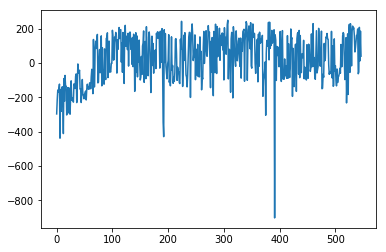

In [14]:
%matplotlib inline
plt.plot(rs)

<IPython.core.display.Javascript object>


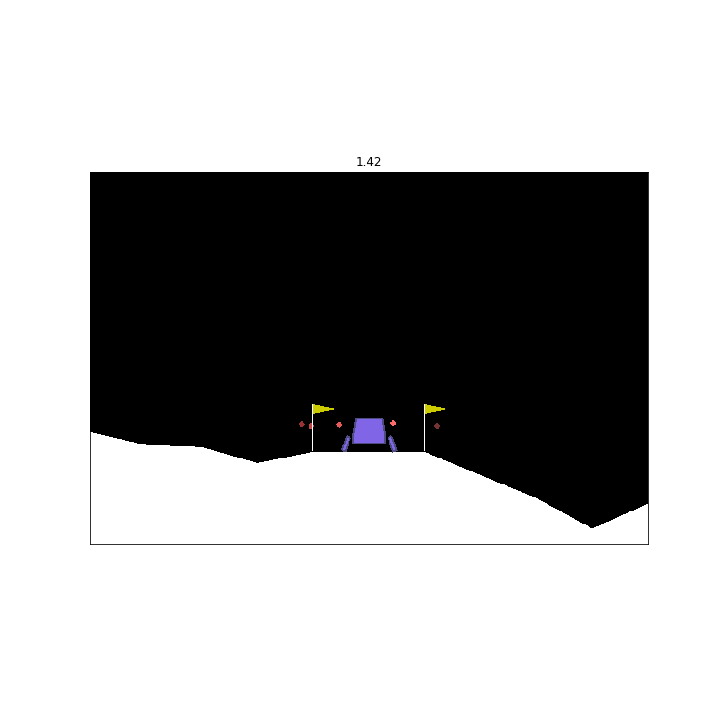

230.8107583892089
181.59426759753268
-157.97341042032858
180.297009752657
77.7166701567185


<IPython.core.display.Javascript object>


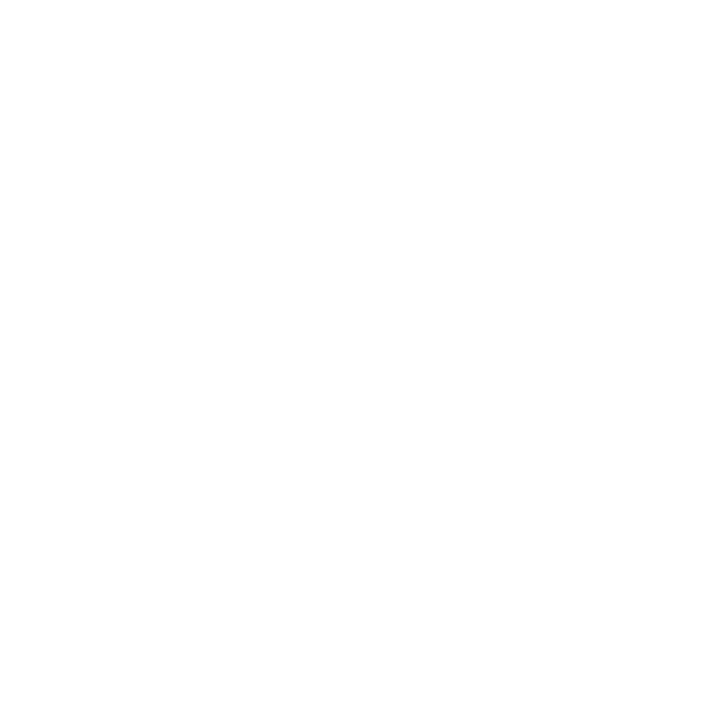

In [17]:
%matplotlib notebook

def render():
    fig.canvas.draw()
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title('%.2f'%reward)
    img.set_data(env.render(mode='rgb_array'))

fig, ax = plt.subplots(figsize=(10, 10))
img = ax.imshow(env.render(mode='rgb_array'))

for _ in range(5):
    state = env.reset()
    r = 0
    render()
    while True:
        action = agent.choose_action([state])
        next_state, reward, done, _ = env.step(action)
        r += reward
        state = next_state
        render()
        if done:
            break
    print(r)